<center>
    <h1> ILI285 - Computación Científica I  / INF285 - Computación Científica </h1>
    <h2> Floating Point Arithmetic </h2>
    <h2> [[S]cientific [C]omputing [T]eam](#acknowledgements)</h2>
    <h2> Version: 1.1</h2>
</center>


## Table of Contents
* [Introduction](#intro)
* [The nature of floating point numbers](#nature)
* [Visualization of floating point numbers](#visualization)
* [Loss of significance](#loss)
* [Loss of significance in funcion evaluation](#func)
* [Another analysis (example from textbook)](#another)
* [Acknowledgements](#acknowledgements)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<div id='intro' />
## Introduction

Hello! This notebook is an introduction to how our computers handle the representation of real numbers using double-presicion floating-point format. To understand the contents of this notebook you should have at least a basic notion of how binary numbers work.

The aforementioned format occupies 64 bits which are divided as follows:

* 1 bit for the sign
* 11 bits for the exponent
* 52 bits for the mantissa

This means that the very next representable number after $1$ is $1 + 2^{-52}$, and their difference, $2^{-52}$, is the $\epsilon _{mach}$.

Additionally, if you'd like to quickly go from a base-2 integer to a base-10 integer and viceversa, Python has some functions that can help you with that.

In [4]:
int('0b11', 2)

3

In [5]:
bin(3)

'0b11'

In [6]:
bin(2**53)

'0b100000000000000000000000000000000000000000000000000000'

<div id='nature' />
## The nature of floating point numbers

As we know until now, float representations of real numbers are just a finite and bounded represetation of them. But another interesting thing, is that these floating numbers are distributed across the real numbers. 

To see that, it's really important to keep in mind the following property:

\begin{equation} \left|\frac{\text{fl}(x)-x}{x}\right| \leq \frac{1}{2} \epsilon_{\text{mach}} \end{equation}

where $\text{fl}(x)$ means the float representation of $x \in R$. What it says is that **the relative error in representing any non-zero real number x, is bounded by a quantity that depends on the system representation** ($\epsilon_{\text{mach}}$).

Maybe now you're thinking: what relationship does this have with the distribution of floating point numbers? So if we rewrite the previous property like this:

\begin{equation} |\text{fl}(x)-x| \leq \frac{1}{2} \epsilon_{\text{mach}} |x| \end{equation}

it's clearer: **The absolute error (distance) between a real number and its floating point representation is proportional to the real number's magnitude.**

Intuitively speaking, if the representation error of a number increases as its magnitude increases, then it's quite natural that **the distance between a floating point number and the next representable floating point number will increase as the magnitude of such number increases (and conversely)**. Could you prove that?  For now we will prove it experimentally.

We will use a library named **bitstring** to handle different number representations. You can install it with:
```
pip install bitstring
```

In [7]:
import bitstring as bs

The next two functions are self-explanatory:

1. `next_float(f)` computes the next representable float number.
2. `epsilon(f)` computes the difference between f and the next representable float number

In [8]:
def next_float(f):
    #packing double-precision foat
    b = bs.pack('>d', f)
    
    #extracting mantisa as unsigned int
    #and adding up 1
    m = b[12:].uint
    m += 1
    
    #putting the result in his place
    b[12:] = m
    
    return b.float

def epsilon(f):
    next_f = next_float(f)
    return next_f - f

So if we compute `epsilon(1)` we should get the epsilon machine number. Let's try it:

In [9]:
epsilon(1)

2.220446049250313e-16

In order to prove our hypotesis, we will create an array of values: [1e-32, 1e-31, ..., 1e31, 1e32] and compute their corresponding epsilon.

In [10]:
#values between 10**-32 and 10**+32
values = np.array([10**i for i in range(-32,32)]).astype(float)

#corresponding epsilons
vepsilon = np.vectorize(epsilon)
eps = vepsilon(values)

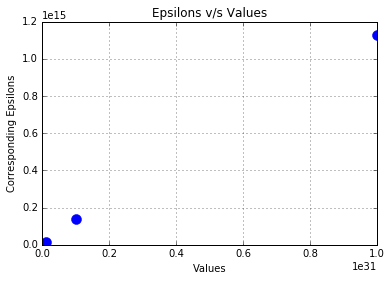

In [37]:
plt.plot(values, eps,'.',markersize=20)
plt.xlabel('Values')
plt.ylabel('Corresponding Epsilons')
plt.title('Epsilons v/s Values')
plt.grid(True)
plt.show()

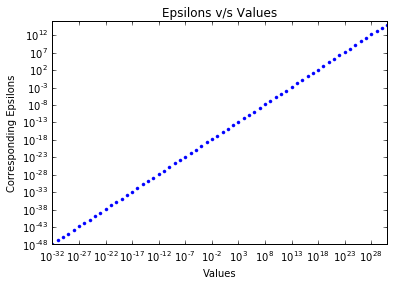

In [38]:
plt.loglog(values, eps,'.')
plt.xlabel('Values')
plt.ylabel('Corresponding Epsilons')
plt.title('Epsilons v/s Values')
plt.show()

As you can see, the hypotesis was right. In other words: Floating point numbers are not linearly distributed across the real numbers, and the distance between them is proportional to their magnitude. **Tiny numbers (~ 0) are closer between each other than bigger numbers are.**

<div id='visualization' />
## Visualization of floating point numbers

With the help of `bitstring` library we could write a function to visualize floating point numbers in his binary representation 

In [13]:
def to_binary(f):
    b = bs.pack('>d', f)
    b = b.bin
    #show sign + exponent + mantisa
    print(b[0]+' '+b[1:12]+ ' '+b[12:])

Let's see some intereseting examples

In [14]:
to_binary(1.)

0 01111111111 0000000000000000000000000000000000000000000000000000


In [15]:
to_binary(1.+epsilon(1.))

0 01111111111 0000000000000000000000000000000000000000000000000001


In [16]:
to_binary(+0.)

0 00000000000 0000000000000000000000000000000000000000000000000000


In [17]:
to_binary(-0.)

1 00000000000 0000000000000000000000000000000000000000000000000000


In [18]:
to_binary(np.inf)

0 11111111111 0000000000000000000000000000000000000000000000000000


In [19]:
to_binary(-np.inf)

1 11111111111 0000000000000000000000000000000000000000000000000000


In [20]:
to_binary(np.nan)

0 11111111111 1000000000000000000000000000000000000000000000000000


In [21]:
to_binary(-np.nan)

1 11111111111 1000000000000000000000000000000000000000000000000000


In [22]:
to_binary(2.**-1074)

0 00000000000 0000000000000000000000000000000000000000000000000001


In [23]:
print(2.**-1074)

5e-324


In [24]:
to_binary(2.**-1075)

0 00000000000 0000000000000000000000000000000000000000000000000000


In [25]:
print(2.**-1075)

0.0


<div id='loss' />
## Loss of significance

As we mentioned, there's a small leap between 1 and the next representable number, which means that if you want to represent a number between those two, you won't be able to do so; that number is nonexistent as it is for the computer, so it'll have to round it to a representable number before storing it in memory.

In [26]:
a = 1.
b = 2.**(-52) #emach
result_1 = a + b     # arithmetic result is 1.0000000000000002220446049250313080847263336181640625
result_1b = result_1-1.0
print("{0:.1000}".format(result_1))
print(result_1b)
print(b)

1.0000000000000002220446049250313080847263336181640625
2.220446049250313e-16
2.220446049250313e-16


In [27]:
c = 2.**(-53)
result_2 = a + c     # arithmetic result is 1.00000000000000011102230246251565404236316680908203125
np.set_printoptions(precision=16)
print("{0:.1000}".format(result_2))
print(result_2-a)

1.0
0.0


In [28]:
d = 2.**(-53) + 2.**(-54)

result_3 = a + d     # arithmetic result is 1.000000000000000166533453693773481063544750213623046875
print("{0:.1000}".format(result_3))

1.0000000000000002220446049250313080847263336181640625


As you can see, if you try to save a number between $1$ and $1 + \epsilon _{mach}$, it will have to be rounded (according to some criteria) to a representable number before being stored, thus creating a difference between the <i>real</i> number and the <i>stored</i> number. This situation is an example of loss of significance.

Does that mean that the "leap" between representable numbers is <i>always</i> going to be $\epsilon _{mach}$? Of course not! Some numbers will require smaller leaps, and some others will require bigger leaps. 

The distance between numbers depends on between which powers of two the number is (I need help redacting this part). For example, all the numbers between $2^{-1}$ and $2^0$ (but excluding $2^0$) have a distance of $\epsilon _{mach}/2$ between them. All the numbers between $2^0$ and $2^1$ (excluding $2^1$) have a distance of $\epsilon _{mach}$ between them. Those between $2^1$ and $2^2$ (not including $2^2$) have a distance of $2\,\epsilon _{mach}$ between them, and so on and so forth.

In [29]:
e = 2.**(-1)
f = b/2. # emach/2

result_4 = e + f     # 0.50000000000000011102230246251565404236316680908203125
print("{0:.1000}".format(result_4))

result_5 = e + b     # 0.5000000000000002220446049250313080847263336181640625
print("{0:.1000}".format(result_5))

0.50000000000000011102230246251565404236316680908203125
0.5000000000000002220446049250313080847263336181640625


In [30]:
g = b/4.

result_5 = e + g     # 0.500000000000000055511151231257827021181583404541015625
print("{0:.1000}".format(result_5))

0.5


We'll let the students find some representable numbers and some non-representable numbers. It's important to note that loss significance can occur in many more operations and functions other that the simple addition of two numbers.

In [31]:
num_1 = a
num_2 = b
result = a + b
print("{0:.1000}".format(result))

1.0000000000000002220446049250313080847263336181640625


<div id='func' />
## Loss of significance in function evaluation

Loss of Significance is present too in the representation of **functions**. A classical example (which you can see in the guide book), is the next function: 

\begin{equation}f(x)= \frac{1 - \cos x}{\sin^{2}x} \end{equation}

Applying trigonometric identities, we can obtain the 'equivalent' function:

\begin{equation}f(x)= \frac{1}{1 + \cos x} \end{equation}


Both of these functions are apparently equals. Nevertheless, its graphics say to us another thing when $x$ is equal to zero. 

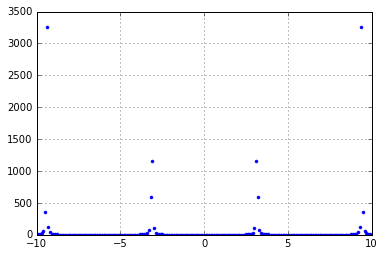

In [39]:
x = np.arange(-10,10,0.1)
y = (1-np.cos(x))/np.sin(x)**2
plt.figure()
plt.plot(x,y,'.')
plt.grid(True)
plt.show()

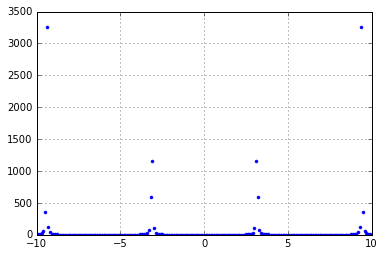

In [40]:
x = np.arange(-10,10,0.1)
y = 1/(1+np.cos(x))
plt.figure()
plt.plot(x,y,'.')
plt.grid(True)
plt.show()

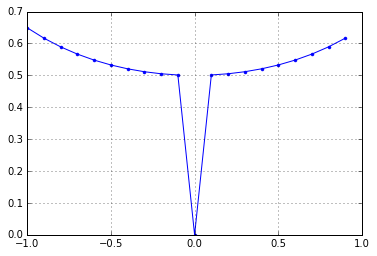

In [41]:
x = np.arange(-1,1,0.1)
y = (1-np.cos(x))/np.sin(x)**2
plt.figure()
plt.plot(x,y,'.-')
plt.grid(True)
plt.show()

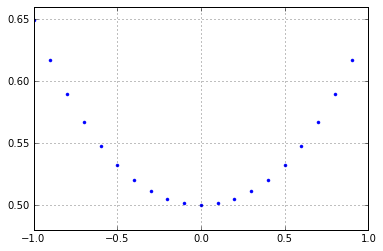

In [42]:
y = 1/(1+np.cos(x))
plt.figure()
plt.plot(x,y,'.')
plt.grid(True)
plt.show()

This happens because when $x$ is equal to zero, the first function has an indetermination, but previously, the computer makes a subtraction between numbers that are almost equals. This generates a loss of significance, turning the expression close to this point to be zero. However, modifying this expression to make the second function, eliminates this substraction, fixing the error in its calculation when $x=0$.

In conclusion, for us, two representations of a function can be equals, but for the computer they can be different!

<div id='another' />
## Another analysis (example from textbook)

In [36]:
f1 = lambda x: (1.-np.cos(x))/(np.sin(x)**2)
f2 = lambda x: 1./(1+np.cos(x))
x = np.logspace(-19,0,20)[-1:0:-1]
o1 = f1(x)
o2 = f2(x)

print("x,                 f1(x),             f2(x)")
for i in np.arange(len(x)):
    print("%1.15f, %1.15f, %1.15f" % (x[i],o1[i],o2[i]))

x,                 f1(x),             f2(x)
1.000000000000000, 0.649223205204762, 0.649223205204762
0.100000000000000, 0.501252086288577, 0.501252086288571
0.010000000000000, 0.500012500208481, 0.500012500208336
0.001000000000000, 0.500000124992189, 0.500000125000021
0.000100000000000, 0.499999998627931, 0.500000001250000
0.000010000000000, 0.500000041386852, 0.500000000012500
0.000001000000000, 0.500044450291337, 0.500000000000125
0.000000100000000, 0.499600361081322, 0.500000000000001
0.000000010000000, 0.000000000000000, 0.500000000000000
0.000000001000000, 0.000000000000000, 0.500000000000000
0.000000000100000, 0.000000000000000, 0.500000000000000
0.000000000010000, 0.000000000000000, 0.500000000000000
0.000000000001000, 0.000000000000000, 0.500000000000000
0.000000000000100, 0.000000000000000, 0.500000000000000
0.000000000000010, 0.000000000000000, 0.500000000000000
0.000000000000001, 0.000000000000000, 0.500000000000000
0.000000000000000, 0.000000000000000, 0.500000000000000
0.00

## Libraries
### Please make sure you make all of them your BFF!!

* Numpy - IEEE 754 Floating Point Special Values: https://docs.scipy.org/doc/numpy-1.10.0/user/misc.html
* Matplotlib: http://matplotlib.org/examples/pylab_examples/simple_plot.html
* Nice Trick: https://www.dataquest.io/blog/jupyter-notebook-tips-tricks-shortcuts/

<div id='acknowledgements' />
# Acknowledgements
* _Material created by professor Claudio Torres_ (`ctorres@inf.utfsm.cl`) _and assistants: Laura Bermeo, Alvaro Salinas, Axel Simonsen and Martín Villanueva. DI UTFSM. March 2016._